TTL acquisition
==================

In this tutorial we will demonstrate the sequencer based TTL (Transistor-Transistor-Logic) acquisition procedure. The TTL acquisition enables us to count trigger pulses, based on a settable threshold. The acquisition protocol allows us to save the number of triggers in separate bins, or average the triggers on the fly (see section [TTL Acquisitions](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/q1_sequence_processor.html#acquisitions)). We will showcase this functionality by using a QRM of which output $\text{O}^{[1]}$ is directly connected to input $\text{I}^{[1]}$, to both send pulses and acquire the resulting data.

Setup
-----

First, we are going to import the required packages.

In [1]:
from __future__ import annotations

from typing import TYPE_CHECKING, Callable

import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from qcodes.instrument import find_or_create_instrument

from qblox_instruments import Cluster, ClusterType

if TYPE_CHECKING:
    from qblox_instruments.qcodes_drivers.module import QcmQrm

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/tools.html#api-pnp) for more info).

In [2]:
!qblox-pnp list

Devices:
 - 10.10.200.13 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QSE_1" and serial number 00015_2321_005
 - 10.10.200.42 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "QAE-I" and serial number 00015_2321_004
 - 10.10.200.43 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QAE-2" and serial number 00015_2206_003
 - 10.10.200.50 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2219_003
 - 10.10.200.53 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2320_004
 - 10.10.200.70 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number 123-456-789
 - 10.10.200.80 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number not_valid


In [3]:
cluster_ip = "10.10.200.42"
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [4]:

cluster = find_or_create_instrument(
    Cluster,
    recreate=True,
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg=(
        {
            2: ClusterType.CLUSTER_QCM,
            4: ClusterType.CLUSTER_QRM,
            6: ClusterType.CLUSTER_QCM_RF,
            8: ClusterType.CLUSTER_QRM_RF,
        }
        if cluster_ip is None
        else None
    ),
)

#### Get connected modules

In [5]:
def get_connected_modules(cluster: Cluster, filter_fn: Callable | None = None) -> dict[int, QcmQrm]:
    def checked_filter_fn(mod: ClusterType) -> bool:
        if filter_fn is not None:
            return filter_fn(mod)
        return True

    return {
        mod.slot_idx: mod for mod in cluster.modules if mod.present() and checked_filter_fn(mod)
    }

In [6]:
# QRM baseband modules
modules = get_connected_modules(cluster, lambda mod: mod.is_qrm_type and not mod.is_rf_type)
modules

{4: <Module: cluster0_module4 of Cluster: cluster0>}

In [7]:
readout_module = modules[4]

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [8]:
cluster.reset()
print(cluster.get_system_status())

Status: OKAY, Flags: NONE, Slot flags: NONE


c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:1033: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:77: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
            
  self._deprecation_warning()
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:129: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
       

Generate waveforms<a id='gen_wf'></a>
------------------------------

Next, we need to create the waveforms used by the sequence for playback on the outputs. Here, we define a single waveform consisting of a 16 ns block pulse with an amplitude of 0.5.

In [9]:
# Waveform length parameter
waveform_length = 16  # nanoseconds

waveforms = {
    "block": {"data": [0.5 for i in range(0, waveform_length)], "index": 0},
}

Specify acquisitions
--------------------

We need to specify the acquisitions so that the instrument can allocate the required memory for its acquisition list. Here, we create one acquisition that consists of 100 bins, at acquisition index 0.

In [10]:
# Acquisitions
acquisitions = {
    "ttl": {"num_bins": 100, "index": 0},
}

Create Q1ASM programs
--------------------

Now that we have the waveform and acquisition specified, we define a simple Q1ASM program that sequences the waveforms and one that triggers the acquisitions.
We will send 5 block pulses of 16 ns at 1 MHz (with 984 ns in between them). At the same time we will perform a 6000 ns TTL acquisition. Note that 1 MHz is the maximum continuous rate for a TTL acquisition.

The TTL acquisition is carried out with the `acquire_ttl` command that takes four arguments. The first argument is the index of what acquisition should be done, the second specifies in what bin index it is stored, the third toggles the acquisition on or off and finally the fourth argument is the amount of ns to wait. See the section on [Q1ASM instructions](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/q1_sequence_processor.html#instructions) for a more detailed overview of the sequencer instructions.

In [11]:
# Sequence program for AWG.
seq_prog_awg = """
        wait_sync 4           #Wait for sequencers to synchronize and then wait another 4ns.
        move      5,R0        #Loop iterator.
loop:
        play      0,0,16      #Play a block on output path 0 and wait 16ns.
        wait      984         #Wait 984ns
        loop      R0, @loop   #Repeat loop until R0 is 0

        stop                  #Stop the sequence after the last iteration.
"""

# Sequence program for acquiring
seq_prog_acq = """
        wait_sync 4           #Wait for sequencers to synchronize and then wait another 4ns.
        wait 140              #Approximate time of flight
        acquire_ttl 0,0,1,4   #Turn on TTL acquire on input path 0 and wait 4ns.
        wait 6000             #Wait 6000ns.
        acquire_ttl 0,0,0,4   #Turn off TTL acquire on input path 0 and wait 4ns.

        stop                   #Stop sequencer.
"""

Upload sequence
---------------

The sequences are uploaded to the sequencers. We will use sequencer 0 to send the pulses and sequencer 1 to acquire them.

In [12]:
# Add sequence program, waveform and acquisitions to single dictionary.
sequence_awg = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": {},
    "program": seq_prog_awg,
}
sequence_acq = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog_acq,
}

In [13]:
# Upload sequence.
readout_module.sequencer0.sequence(sequence_awg)
readout_module.sequencer1.sequence(sequence_acq)

Play sequence
-------------

Now we configure the sequencers, and play the sequence.

We will use sequencer 0 which will drive output $\text{O}^{1}$, and sequencer 1 which will acquire on input $\text{I}^{1}$, enabling syncing, and prepare the (scope) acquisition.

Then the TTL acquisition is configured by using `ttl_acq_input_select` to select $\text{I}^{1}$ as input. We set `ttl_acq_auto_bin_incr_en` to False such that our TTL count will be put in one bin. We set our TTL threshold to a value of 0.5 of our input range (corresponding to 0.5 V) using `ttl_acq_threshold `, and our input gain to 0 dB using `in0_gain`.

In [14]:
# Map sequencer to specific outputs (but first disable all sequencer connections)
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

# Drive through first output
readout_module.sequencer0.connect_out0("I")

# Acquire through first input
readout_module.sequencer1.connect_acq_I("in0")

# Enable sync
readout_module.sequencer0.sync_en(True)
readout_module.sequencer1.sync_en(True)

# Delete previous acquisition.
readout_module.delete_acquisition_data(1, "ttl")

# Configure scope mode
readout_module.scope_acq_sequencer_select(1)

# Choose threshold and input gain
threshold = 0.5
input_gain = 0

# Configure the TTL acquisition
readout_module.sequencer1.ttl_acq_input_select(0)
readout_module.sequencer1.ttl_acq_auto_bin_incr_en(False)

# Set input gain and threshold
readout_module.in0_gain(input_gain)
readout_module.sequencer1.ttl_acq_threshold(threshold)

We start the sequence, and print the status flags of our sequencers.

In [15]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.arm_sequencer(1)
readout_module.start_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_status(0, 1))
print(readout_module.get_sequencer_status(1, 1))

Status: STOPPED, Flags: NONE
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:2414: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:85: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
            
  self._deprecation_warning()


Retrieve acquisition
--------------------

We retrieve the acquisition data from sequencer 1. Then, both plot the scope data for the first 6000 ns and print the number of counted pulses, that is stored in `data['acquisition']["bins"]["avg_cnt"][0]`.

c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:3210: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(


pulses detected: 5


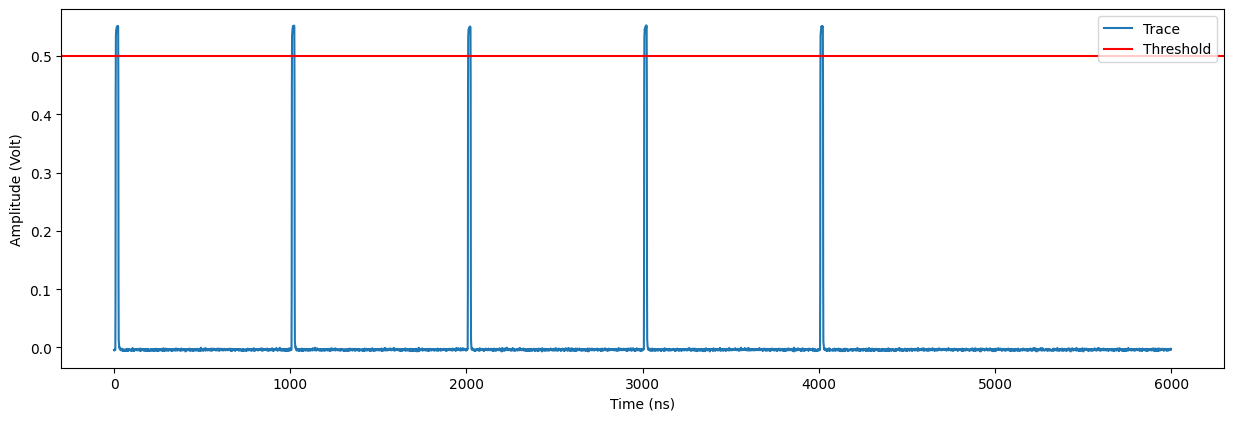

In [16]:
# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_status(1, 1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(1, "ttl")

# Get acquisition list from instrument.
data = readout_module.get_acquisitions(1)["ttl"]

# Plot acquired signal on both inputs.
print("pulses detected: " + str(data["acquisition"]["bins"]["avg_cnt"][0]))

fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(data["acquisition"]["scope"]["path0"]["data"][0:6000], label="Trace")
ax.axhline(y=threshold, color="r", label="Threshold")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Amplitude (Volt)")
plt.legend(loc="upper right")
plt.show()

We observe that we indeed do see five 16 ns pulses in the scope acquisition. Furthermore we observe that the amount of pulses counted matches the amount we of the scope trace. You are encouraged to change the threshold value and input gain yourself, and learn about th importance of calibrating these values.

<div class="alert alert-block alert-warning">
<h1> Note </h1>
It is important to correctly calibrate your input gain and threshold. For example in a setup with noise and/or interferences, setting the input gain too high might result in these kind of pulses:

![download.png](download.png)


Such a single pulse results in multiple counts, as the threshold is passed multiple times. We therefore strongly recommend calibrating the TTL acquisition using the scope acquisition as is shown above.
    </div>

Short pulse bursts
--------------------

As the acquisition module in the sequencer has an internal buffer of 8 data entries, any pulse bursts of <8 will be handled correctly when exceeding the maximum continuous rate of 1 MHz. When exceeding the buffer limit, a `ACQ_BINNING_FIFO_ERROR` will be thrown.
To illustrate this we will define a function `generate_pulse_program` that takes as input `num_pulses` (the number of pulses to generate) and `wait_time` (the time to wait between pulses in ns).
We also define a function to upload the sequence to the AWG.

In [17]:
# Sequence program for AWG.
def generate_pulse_program(num_pulses: int, wait_time: int) -> str:
    seq_prog_awg = f"""
        wait_sync 4           #Wait for sequencers to synchronize and then wait another 4ns.
        move      {num_pulses},R0  #Loop iterator.
loop:
        play      0,0,16      #Play a block on output path 0 and wait 16ns.
        wait      {wait_time} #Wait wait_time ns
        loop      R0, @loop   #Repeat loop until R0 is 0

        stop                  #Stop the sequence after the last iteration.
    """
    return seq_prog_awg


# Upload sequence to AWG
def upload_sequence(seq_prog_awg: str) -> None:
    sequence_awg = {
        "waveforms": waveforms,
        "weights": {},
        "acquisitions": {},
        "program": seq_prog_awg,
    }

    readout_module.sequencer0.sequence(sequence_awg)

We now generate the program, upload it and set the threshold and input gain.

In [18]:
seq_prog_awg = generate_pulse_program(num_pulses=5, wait_time=20)
upload_sequence(seq_prog_awg)

# Choose threshold and input gain
threshold = 0.5
input_gain = 0

# Delete previous acquisition.
readout_module.delete_acquisition_data(1, "ttl")

# Set input gain and threshold
readout_module.in0_gain(input_gain)
readout_module.sequencer1.ttl_acq_threshold(threshold)

We then arm the sequencers and play the sequence.

In [19]:
# Arm and start sequencer.
readout_module.arm_sequencer(0)
readout_module.arm_sequencer(1)
readout_module.start_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_status(0, 1))
print(readout_module.get_sequencer_status(1, 1))

Status: STOPPED, Flags: NONE
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


We retrieve the acquisition and plot it as in the previous section.

pulses detected: 5


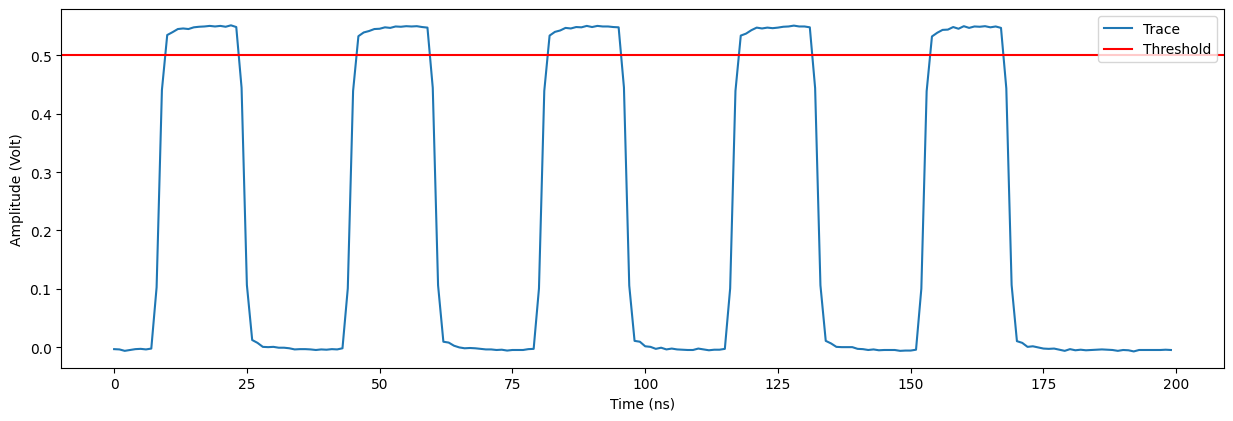

In [20]:
# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_status(1, 1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(1, "ttl")

# Get acquisition list from instrument.
data = readout_module.get_acquisitions(1)["ttl"]

# Plot acquired signal on both inputs (first 200 ns).
print("pulses detected: " + str(data["acquisition"]["bins"]["avg_cnt"][0]))

fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(data["acquisition"]["scope"]["path0"]["data"][0:200], label="Trace")
ax.axhline(y=threshold, color="r", label="Threshold")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Amplitude (Volt)")
plt.legend(loc="upper right")
plt.show()

We encourage you to play around with the `num_pulses`, `wait_time`, `input_gain` and `threshold` yourself.

Auto bin increment
--------------


In the play sequence section we set the `ttl_acq_auto_bin_incr_en` to False, meaning all of our pulses get counted within one bin. When it is set to True our data will be stored in separate bins, where the bin index is incremented by one for every detected pulse. The pulse count is therefore equal to the number of valid bins. When doing multiple measurements, this allows us to acquire a cumulative probability distribution of counted triggers.

To illustrate the usage we will define a function which returns a Q1ASM program that plays a `N` amount of pulses (at a 1 MHz rate), where `N` is a random number between 1 and 100 taken from a Poissonian distribution. This is meant to mock a stochastic physical process, e.g the amount of photons emitted by a laser.
We will call the function a 1000 times and run it, without deleting the acquisition data between the runs.
After this we will plot a histogram from our acquired data to inspect the result.

We will now define new Q1ASM programs. We define a function which returns a program that generates `num_pulses` number of pulses. These pulses are 16 ns long, and are send at a rate of 1 MHz again.

For the acquiring sequencer we will execute the same program as in the previous section, albeit with an acquisition window of 100.000 ns.

In [21]:
# Sequence program for acquiring
seq_prog_acq = """
        move      10,R0       #Loop iterator.
        wait_sync 4           #Wait for sequencers to synchronize and then wait another 4ns.
        wait 140              #Approximate time of flight
        acquire_ttl 0,0,1,4   #Turn on TTL acquire on input path 0 and wait 4ns.
loop:
        wait 10000            #Wait 10000 ns
        loop      R0, @loop   #Repeat loop until R0 is 0
        acquire_ttl 0,0,0,4   #Turn off TTL acquire on input path 0 and wait 4ns.

        stop                   #Stop sequencer.
"""

We will first configure our sequencers. Then use `random` to generate an amount of pulses, and repeat this 10000 times.

In [22]:
# Choose threshold and input gain
threshold = 0.5
input_gain = 0

# Delete previous acquisition.
readout_module.delete_acquisition_data(1, "ttl")

# Configure the TTL acquisition
readout_module.sequencer1.ttl_acq_input_select(0)
readout_module.sequencer1.ttl_acq_auto_bin_incr_en(True)

# Enable sync
readout_module.sequencer0.sync_en(True)
readout_module.sequencer1.sync_en(True)

# Set input gain and threshold
readout_module.in0_gain(input_gain)
readout_module.sequencer1.ttl_acq_threshold(threshold)

sequence_acq = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog_acq,
}

# Upload acquire sequence.
readout_module.sequencer1.sequence(sequence_acq)

# Map sequencer to specific outputs (but first disable all sequencer connections)
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

# Drive through first output
readout_module.sequencer0.connect_out0("I")

# Acquire through first input
readout_module.sequencer1.connect_acq_I("in0")

In [23]:
num_pulses_list = random.poisson(lam=50, size=1000)
wait_time = 1000

for num_pulses in num_pulses_list:
    seq_prog_awg = generate_pulse_program(num_pulses, wait_time)
    upload_sequence(seq_prog_awg)
    # Arm and start sequencer.
    readout_module.arm_sequencer(0)
    readout_module.arm_sequencer(1)
    readout_module.start_sequencer()
    readout_module.get_acquisition_status(1, 1)

### Create histogram

We retrieve the acquired data from the sequence to take a look at it.

In [24]:
# Wait for the sequencer to stop with a timeout period of one minute.
readout_module.get_acquisition_status(1, 1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(1, "ttl")

# Get acquisition list from instrument.
data = readout_module.get_acquisitions(1)["ttl"]["acquisition"]["bins"]["avg_cnt"]

# Plot acquired signal on both inputs.
print(f"counts per bin: {data}")

counts per bin: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 998, 997, 995, 994, 994, 991, 987, 978, 969, 948, 925, 904, 880, 860, 815, 769, 726, 674, 624, 567, 512, 461, 404, 348, 305, 259, 222, 185, 157, 134, 104, 74, 53, 39, 30, 24, 19, 12, 8, 6, 5, 4, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Every time the acquisition_ttl is ran the sequencer starts over with incrementing the bins (from bin 0). In every bin, the counts are summed up for all 1000 runs. Therefore, the data is a cumulative probability distribution of triggers counted. We now reorganize the acquired data into a probability distribution function (a histogram), and plot the result.

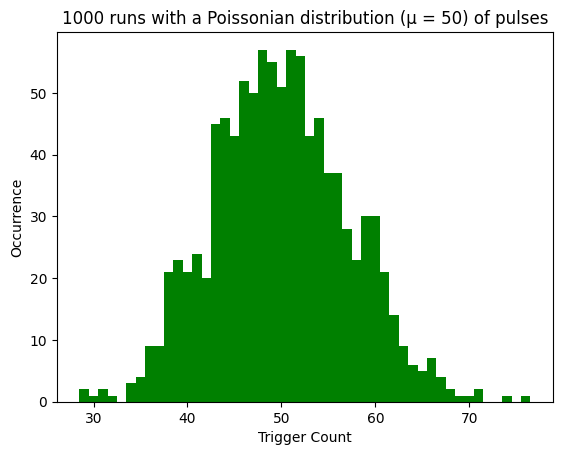

In [25]:
def create_histogram(data: list) -> dict[int, float]:
    data_diff = np.diff(data)
    res = {
        count + 1: -v
        for (count, v) in enumerate(data_diff)
        if not (np.isnan(v) or np.isclose(v, 0))
    }
    return res


res = create_histogram(data)
plt.bar(res.keys(), res.values(), 1, color="g")
plt.title("1000 runs with a Poissonian distribution (µ = 50) of pulses")
plt.xlabel("Trigger Count")
plt.ylabel("Occurrence")
plt.show()

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before
closing the connection by uncommenting the corresponding lines.

In [26]:
# Stop sequencer.
readout_module.stop_sequencer()

# Print status of sequencer.
print(readout_module.get_sequencer_status(0))
print()

# Print an overview of the instrument parameters.
print("Snapshot:")
readout_module.print_readable_snapshot(update=True)

# Reset the cluster
cluster.reset()
print(cluster.get_system_status())

Status: STOPPED, Flags: FORCED_STOP

Snapshot:


cluster0_module4:
	parameter                    value
--------------------------------------------------------------------------------
in0_gain                      :	0 (dB)
in0_offset                    :	0 (V)
in1_gain                      :	-6 (dB)
in1_offset                    :	0 (V)
marker0_inv_en                :	False 
marker1_inv_en                :	False 
marker2_inv_en                :	False 
marker3_inv_en                :	False 
out0_offset                   :	0 (V)
out1_offset                   :	0 (V)
present                       :	True 
scope_acq_avg_mode_en_path0   :	False 
scope_acq_avg_mode_en_path1   :	False 
scope_acq_sequencer_select    :	1 
scope_acq_trigger_level_path0 :	0 
scope_acq_trigger_level_path1 :	0 
scope_acq_trigger_mode_path0  :	sequencer 
scope_acq_trigger_mode_path1  :	sequencer 


cluster0_module4_sequencer0:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	I 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns

cluster0_module4_sequencer1:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer2:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer3:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer4:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer5:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	off 
connect_acq_Q                    :	off 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

Status: OKAY, Flags: NONE, Slot flags: NONE
